In [24]:
#From:
#   http://stackoverflow.com/questions/37144423/all-possible-maximum-matchings-of-a-bipartite-graph

import networkx as nx
import matplotlib.pyplot as plt

def checkAll(G,m):
    b = nx.bipartite.eppstein_matching(G) # Finds first match
    c = []
        
    b2 = nx.bipartite.eppstein_matching(G) # Finds first match
    
    c2 = list(b2.keys())
    for y in c2[int(len(c2)/2):]: # Reduces to one occurrence per line
        b2.pop(y)
    if len(b2) != m: # If new size, break
        return 0
    return b2 # Add to list of possibilities

def remove_matches(G):
    '''
    Given a graph, remove the bipartite matchings that are repeats
    '''
    
    b = nx.bipartite.eppstein_matching(G) # Finds first match
    c = []
    for k in list(b.keys()):
        #Check for duplicate loops
        if (b[k] in b) and (b[k] not in c):
            if b[b[k]]==k:
                c += [k]
    for y in range(len(c)): # Reduces to one occurrence per line
        b.pop(c[y])
        
    if len(b)>0:
        return b
    else:
        return 0

    
def my_maximal_matching(G):
    '''
    Given a graph, iterate through the edges to return all possible maximal matchings
    '''
    
    edges = G.edges()
    A = []
    for x in range(len(edges)):
        #import pdb
        #pdb.set_trace()
        b = checkAll(G,m)
        if b:
            A += [b]
        else:
            break
        keys = list(b.keys())
        cache = (keys[0],b[keys[0]])
        removed = []
        while 1:
            try:
                removed += [(keys[1],b[keys[1]])]
                G.remove_edge(keys[1],b[keys[1]]) # Remove first option
                b = checkAll(G,m)
                if b and cache == (keys[0],b[keys[0]]):
                    A += [b]
                else:
                    break
            except:
                break
        G.add_edges_from(removed)
        G.remove_edge(*edges[x])
        

def maximal_matching(G):
    edges = G.edges()
    A = []
    m = len(nx.bipartite.eppstein_matching(G))/2 # Create an expected maximum
    for x in range(len(edges)):
        #import pdb
        #pdb.set_trace()
        b = checkAll(G,m)
        if b:
            A += [b]
        else:
            break
        keys = list(b.keys())
        cache = (keys[0],b[keys[0]])
        removed = []
        while 1:
            try:
                removed += [(keys[1],b[keys[1]])]
                G.remove_edge(keys[1],b[keys[1]]) # Remove first option
                b = checkAll(G,m)
                if b and cache == (keys[0],b[keys[0]]):
                    A += [b]
                else:
                    break
            except:
                break
        G.add_edges_from(removed)
        G.remove_edge(*edges[x])

    return A

def print_matching(A):
    print(list(eval(x) for x in set(str(x) for x in A)))

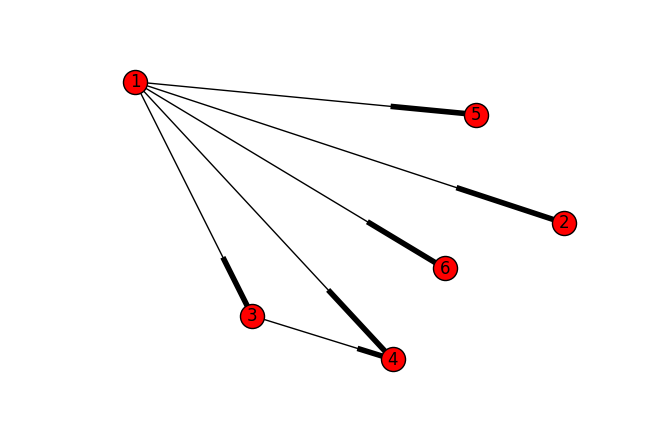

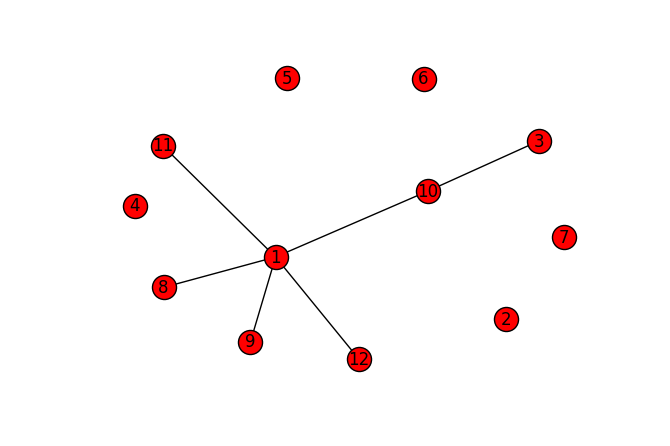

[{8: 1, 1: 8, 10: 3, 3: 10}, {9: 1, 10: 3, 3: 10, 1: 9}, {9: 1, 1: 9}, {3: 10, 1: 11, 10: 3, 11: 1}, {1: 12, 10: 3, 3: 10, 12: 1}, {3: 10, 1: 11, 10: 3, 11: 1}, {1: 12, 10: 3, 3: 10, 12: 1}, {10: 3, 3: 10}, {1: 12, 10: 3, 3: 10, 12: 1}, {1: 12, 12: 1}, {10: 3, 3: 10}]


In [25]:
import networkx as nx
import TestNetworks as tn
import matplotlib.pyplot as plt
import Maximal_matching as mm
import DigraphConvert as dc

%matplotlib inline

G = tn.testNet(3)
nx.draw(G,with_labels=True);plt.show()
BiG = dc.digraphToBipartite(G)
nx.draw(BiG,with_labels=True);plt.show()
mlist = maximal_matching(BiG)
print(mlist)

In [23]:
c2 = [1,2,3,4,5]
print(c2[int(len(c2)/2):])

[3, 4, 5]
